# Evolutionary computing
## Assignment III

### Table of Contents
* [Statement](##Statement)
    * [Libraries](###Libraries)
    * [3D surface](###3D_surface)
    * [Parameters](###Parameters)
* [Functions](##Functions)
    * [Binary representation](###Binary_representation)
    * [Real representation](###Real_representation)
    * [Common](###Common)
* [Executive](##Executive)
    * [Binary representation](###Binary_executive)
    * [Real representation](###Real_executive)
* [Results](##Results)
    * [Statistics](###Statistics)
    * [Convergence](###Convergence)
    * [Numerical results](###Numerical_results)

## Statement

### Libraries

In [24]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid') 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pandas as pd

from numba import jit, cuda 
from scipy.stats import ranksums
import numpy as np
import random

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

import logging;
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
logging.disable(logging.WARNING)

### 3D_surface

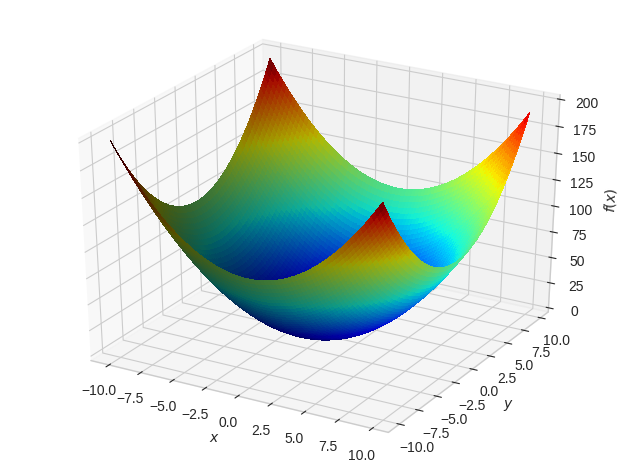

In [25]:
fig = plt.figure()
ax = fig.gca(projection='3d')

X=np.arange(-10,10,0.25)
Y=np.arange(-10,10,0.25)
X,Y = np.meshgrid(X,Y)
Z = X**2 + Y**2

my_col = cm.jet(Z/np.amax(Z))

surf = ax.plot_surface(X,Y,Z,linewidth=0,antialiased=False, rstride=1, cstride=1, facecolors = my_col)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$f(x)$')
fig.tight_layout()

plt.show()

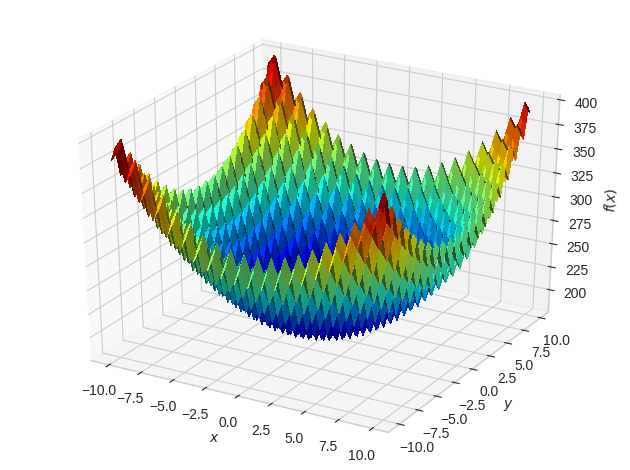

In [26]:
fig = plt.figure()
ax = fig.gca(projection='3d')

X=np.arange(-10,10,0.25)
Y=np.arange(-10,10,0.25)
X,Y = np.meshgrid(X,Y)
Z = 10*10 + X**2 - 10*np.cos(2*np.pi*X) + 10*10 + Y**2 - 10*np.cos(2*np.pi*Y)

surf = ax.plot_surface(X,Y,Z,linewidth=0,antialiased=False, rstride=1, cstride=1, facecolors = my_col)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$f(x)$')
fig.tight_layout()
plt.show()

### Parameters

In [27]:
'''Parámetros de entrada
'''
ppl_size = 50 #int(input("Tamaño de la población: "))
generations = 1000 #int(input("Número de generaciones: "))
p_crossover = 0.85 #float(input("Porcentaje de cruza: "))
p_mutation = 0.25 #float(input("Porcentaje de mutación: "))

max_evals = ppl_size*generations
executions = 30

## Functions

### Binary_representation

In [28]:
@jit(target_backend='cuda')
def generateBinarySolution(case):
    if (case == 1):
        return np.random.randint(2, size=10*15)
    if (case == 2):
        return np.random.randint(2, size=10*14)

def deterministicSampling(population, apptitudes, no_parents):
    integers = []
    decimals = []
    net_fit = np.array(apptitudes).sum(axis=0)[1]
    for fit_i in apptitudes:
        expected = (fit_i[1]/net_fit)*len(population)
        i, d = divmod(expected, 1)
        decimals.append((fit_i[0],d))
        if (i == 1.0):
            integers.append(fit_i[0])
    decimals = sorted(decimals,key=lambda l:l[1], reverse=True)
    parents = []
    # Si hay suficientes 1 usarlos
    if (len(integers) >= no_parents):
        for cc in range(no_parents):
            indx = integers[cc]
            parents.append(population[indx])
    # Si no hay suficientes usar los que existan
    elif (len(integers) > 0 and len(integers) < no_parents):
        for dd in integers:
            parents.append(population[dd])
    kk = 0
    # Si faltan padres tomar de los decimales
    while (len(parents) < no_parents):
        parents.append(population[decimals[kk][0]])
        kk += 1
    return parents

@jit(target_backend='cuda')
def binaryCrossover(solution1, solution2):    
    cross_pt = random.randint(1, solution1.size-1)
    first_half1  = solution1[:cross_pt]
    second_half1 = solution1[cross_pt:]
    first_half2  = solution2[:cross_pt]
    second_half2 = solution2[cross_pt:]
    sol_1 = np.concatenate((first_half1,second_half2))
    sol_2 = np.concatenate((first_half2,second_half1))
    return sol_1, sol_2

@jit(target_backend='cuda')
def binaryMutation(solution):
    index = random.randint(1, solution.size-1)
    if (solution[index] == 0):
        solution[index] = 1
    else:
        solution[index] = 0
    return solution

### Real_representation

In [29]:
@jit(target_backend='cuda')
def generateRealSolution(case):
    if (case == 1):
        sol_1 = np.random.uniform(-10,10,10)
        return np.round(sol_1, decimals=3)
    if (case == 2):
        sol_2 = np.random.uniform(-5.12,5.12,10)
        return np.round(sol_2, decimals=3)

def deterministicTournament(population, apptitudes):
    indx_lst = random.sample(range(0, ppl_size), 4)
    parents_subset = []
    for indx in indx_lst:
        parents_subset.append(apptitudes[indx])
    parents_subset.sort(key=lambda a: a[1])
    index_1 = parents_subset[0][0]
    index_2 = parents_subset[1][0]
    parent_1 = population[index_1]
    parent_2 = population[index_2]
    return parent_1, parent_2

@jit(target_backend='cuda')
def realCrossover(good_solution,bad_solution,alpha,beta):
    H = []
    k = len(good_solution)
    for i in range(0, k):
        I = abs(good_solution[i] - bad_solution[i])
        if (good_solution[i] < bad_solution[i]):
            Li = good_solution[i] - alpha*I
            Ls = bad_solution[i] + beta*I
        else:
            Li = bad_solution[i] - beta*I
            Ls = good_solution[i] + alpha*I
        h_i = np.random.uniform(Li,Ls)
        H.append(h_i)
    son = np.array(H)
    return np.round(son, decimals=3)

@jit(target_backend='cuda')
def realMutation(solution, case):
    if (case ==1):
        Linf = -10
        Lsup = 10
    if (case ==2):
        Linf = -5.12
        Lsup = 5.12
    index = random.randint(1, solution.size-1)
    solution[index] = np.random.uniform(Linf,Lsup,1)[0]
    return np.round(solution, decimals=3)

### Common

In [30]:
@jit(target_backend='cuda')
def decodeBin2Real(binSolution, case):
    if (case ==1):
        Linf = -10
        Lsup = 10
        L = 15
    if (case ==2):
        Linf = -5.12
        Lsup = 5.12
        L = 14
    RealSolution = []
    d_splits = np.split(binSolution, 10)
    for split_indx in range(10):
        x = d_splits[split_indx]
        x_integer = 0
        for local_indx in range(L):
            if (x[local_indx] ==1):
                x_integer += 2**(L-1-local_indx)
        x_real = Linf + (x_integer*(Lsup - Linf))/(2**L - 1)
        RealSolution.append(x_real)
    RealSolution = np.round(np.array(RealSolution), decimals=3)
    return RealSolution

@jit(target_backend='cuda')
def fitness(x, case, isBin = False):
    if (isBin == True):
        x = decodeBin2Real(x,case)  
    if (case == 1):
        fit = np.sum(x**2)
    if (case == 2):
        fit = 10*10 + np.sum(x**2 - 10*np.cos(2*np.pi*x)) 
    return np.round(fit, decimals=3)

@jit(target_backend='cuda')
def generatePopulation(size, case, isBin):
    population = []
    apptitudes = []
    for index in range (0,size):
        if (isBin == True):
            solution = generateBinarySolution(case)
        else:
            solution = generateRealSolution(case)
            solution = np.round(solution, decimals=3)
        apptitude = fitness(solution,case,isBin)
        apptitudes.append((index,apptitude))
        population.append(solution)
    return population, apptitudes

## Executive

### Binary_executive

In [31]:
def executeBinaryRepresentation(c, printScore):
    bestApptitude = []
    averageApptitude = []
    best_solution = 0
    population, apptitudes = generatePopulation(ppl_size,case=c,isBin=True)
    evals = 0
    gens = 0
    while (evals < max_evals):
        no_parents = 10
        midle_indx = int(no_parents/2)
        parents = deterministicSampling(population, apptitudes, no_parents)
        sons_a = []
        sons_b = []
        pc = np.random.uniform(0,1,1)[0]
        if (pc <= p_crossover):
            for i in range(midle_indx):
                son_a, son_b = binaryCrossover(parents[i], parents[midle_indx+i])                
                sons_a.append(son_a)
                sons_b.append(son_b)
        else:
            for i in range(midle_indx):
                sons_a.append(parents[i])
                sons_b.append(parents[midle_indx+i])

        pm = np.random.uniform(0,1,1)[0]
        if (pm <= p_mutation):
            for i in range(midle_indx):
                sons_a[i] = binaryMutation(sons_a[i])
                sons_b[i] = binaryMutation(sons_b[i])

        for i in range(midle_indx):
            population.append(sons_a[i])
            population.append(sons_b[i])

        nuevas_aptitudes = []
        for index in range (0,len(population)):
            apptitude = fitness(population[index],case=c,isBin=True)
            nuevas_aptitudes.append((index,apptitude))

        nuevas_aptitudes.sort(key=lambda a: a[1])

        nueva_poblacion = []
        for i in nuevas_aptitudes:
            nueva_poblacion.append(population[i[0]])

        nuevas_aptitudes.clear()
        nueva_poblacion = nueva_poblacion[:ppl_size]     
        average_fit = 0
        for i in range(0,len(nueva_poblacion)):
            apptitude = fitness(nueva_poblacion[i],case=c,isBin=True)
            average_fit += apptitude
            nuevas_aptitudes.append((i,apptitude))
            evals += 1
        population = nueva_poblacion
        apptitudes = nuevas_aptitudes
        average_fit = average_fit/ppl_size
        bestApptitude.append(apptitudes[0][1])
        averageApptitude.append(average_fit)
        son_decoded = decodeBin2Real(population[apptitudes[0][0]],c) 
        if (evals % ppl_size == 0):
            gens += 1
            if (printScore == True):
                print(son_decoded, "f(x)", apptitudes[0][1], "Gen", gens)
    return bestApptitude, averageApptitude, son_decoded

In [32]:
bbest_appt_1, avg_appt_1, bbest_son_1 = executeBinaryRepresentation(1, True)

/tmp/ipykernel_8369/360338562.py:40: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "generateBinarySolution" failed type inference due to: No implementation of function Function(<built-in method randint of numpy.random.mtrand.RandomState object at 0x7fce28571c40>) found for signature:
 
 >>> randint(Literal[int](2), size=Literal[int](150))
 
There are 6 candidate implementations:
      - Of which 2 did not match due to:
      Overload in function 'np_randint_impl_1': File: numba/cpython/randomimpl.py: Line 568.
        With argument(s): '(int64, size=int64)':
       Rejected as the implementation raised a specific error:
         TypingError: got an unexpected keyword argument 'size'
  raised from /home/jhermosilla/.local/lib/python3.8/site-packages/numba/core/typing/templates.py:784
      - Of which 4 did not match due to:
      Overload in function 'np_randint_impl_2': File: numba/cpython/randomimpl.py: Line 574.
        With argum

[-3.437 -4.364  6.101 -2.495 -2.639 -2.375  0.288  1.007 -2.378  6.708] f(x) 138.659 Gen 1
[-3.437 -4.364  6.101 -2.495 -2.639 -2.375  0.288  1.007 -2.378  6.708] f(x) 138.659 Gen 2
[-3.437 -4.364  6.101 -2.495 -2.639 -2.375  0.288  1.007 -2.378  6.708] f(x) 138.659 Gen 3
[-3.437 -4.364  6.101 -2.495 -2.639 -2.375  0.288  1.007 -2.378  6.708] f(x) 138.659 Gen 4
[-3.437 -4.364  6.101 -2.495 -2.639 -2.375  0.288  1.007 -2.378  6.708] f(x) 138.659 Gen 5
[-3.437 -4.364  6.101 -2.495 -2.639 -2.375  0.288  1.007 -2.378  6.708] f(x) 138.659 Gen 6
[-3.437 -4.364  6.101 -2.495 -2.639 -2.375  0.288  1.007 -2.378  6.708] f(x) 138.659 Gen 7
[-3.437 -4.364  6.101 -2.495 -2.639 -2.375  0.288  1.007 -2.378  6.708] f(x) 138.659 Gen 8
[-3.437 -4.364  6.101 -2.495 -2.639 -2.375  0.288  1.007 -2.378  6.708] f(x) 138.659 Gen 9
[-3.385 -0.5   -3.024 -4.786 -4.294 -0.429  2.215 -2.24   2.978 -5.956] f(x) 116.647 Gen 10
[-3.385 -0.5   -3.024 -4.786 -4.289 -0.429  2.21   2.276 -0.612 -6.331] f(x) 112.859 Gen 

In [33]:
bbest_appt_2, avg_appt_2, bbest_son_2 = executeBinaryRepresentation(2, True)

[ 0.252 -2.726  3.434 -1.255  0.625  1.269  1.997 -2.063  2.114 -1.107] f(x) 121.566 Gen 1
[ 0.252 -2.726  3.434 -1.255  0.625  1.269  1.997 -2.063  2.114 -1.107] f(x) 121.566 Gen 2
[ 0.252 -2.726  3.434 -1.255  0.625  1.269  1.997 -2.063  2.114 -1.107] f(x) 121.566 Gen 3
[ 2.635  1.242  3.069  0.822  1.14  -0.973 -2.144 -5.025 -0.05  -3.674] f(x) 119.638 Gen 4
[ 2.635  1.242  3.069  0.822  1.14  -0.973 -2.144 -5.025 -0.05  -3.674] f(x) 119.638 Gen 5
[ 2.635  1.242  3.069  0.822  1.14  -0.973 -2.144 -5.025 -0.05  -3.674] f(x) 119.638 Gen 6
[ 2.635  1.242  3.069  0.822  1.14  -0.973 -2.144 -5.025 -0.05  -3.674] f(x) 119.638 Gen 7
[ 2.635  1.242  3.069  0.822  1.14  -0.973 -2.144 -5.025 -0.05  -3.674] f(x) 119.638 Gen 8
[ 2.075 -3.921 -1.157  1.082 -0.334 -2.998  1.944  4.911  3.712  1.877] f(x) 116.945 Gen 9
[ 2.075 -3.921 -1.157  1.082 -0.334 -2.998  1.944  4.911  3.712  1.877] f(x) 116.945 Gen 10
[ 2.075 -3.921 -1.157  1.082 -0.334 -2.998  1.944  4.911  3.712  1.877] f(x) 116.945 Gen 

### Real_executive

In [34]:
def executeRealRepresentation(c, printScore):
    bestApptitude = []
    averageApptitude = []
    best_solution = 0
    population, apptitudes = generatePopulation(ppl_size,case=c,isBin=False)
    evals = 0
    gens = 0
    while (evals < max_evals):
        parent_1, parent_2 = deterministicTournament(population, apptitudes)
        fit_1 = fitness(parent_1,case=c,isBin=False)
        fit_2 = fitness(parent_2,case=c,isBin=False)
        if (fit_1 < fit_2):
            son_1 = realCrossover(parent_1, parent_2, 0.5, 0.5)
            son_2 = realCrossover(parent_1, parent_2, 0.5, 0.5)
        else: 
            son_1 = realCrossover(parent_2, parent_1, 0.5, 0.5)
            son_2 = realCrossover(parent_2, parent_1, 0.5, 0.5)

        pm = np.random.uniform(0,1,1)[0]
        if (pm <= p_mutation):
            son_1 = realMutation(son_1,c)
            son_2 = realMutation(son_2,c)
        else:
            son_1, son_2 = parent_1, parent_2

        population.append(son_1)
        population.append(son_2)

        nuevas_aptitudes = []
        for index in range (0,len(population)):
            apptitude = fitness(population[index],case=c,isBin=False)
            nuevas_aptitudes.append((index,apptitude))

        nuevas_aptitudes.sort(key=lambda a: a[1])

        nueva_poblacion = []
        for i in nuevas_aptitudes:
            nueva_poblacion.append(population[i[0]])

        nuevas_aptitudes.clear()
        nueva_poblacion = nueva_poblacion[:ppl_size]     
        average_fit = 0
        for i in range(0,len(nueva_poblacion)):
            apptitude = fitness(nueva_poblacion[i],case=c,isBin=False)
            average_fit += apptitude
            nuevas_aptitudes.append((i,apptitude))
            evals += 1
        population = nueva_poblacion
        apptitudes = nuevas_aptitudes
        average_fit = average_fit/ppl_size
        bestApptitude.append(apptitudes[0][1])
        averageApptitude.append(average_fit)
        if (evals % ppl_size == 0):
            gens += 1
            if (printScore == True):
                print(population[apptitudes[0][0]], "f(x)", apptitudes[0][1], "Gen", gens)
    return bestApptitude, averageApptitude, population[apptitudes[0][0]]

In [35]:
bbest_appt_3, avg_appt_3, bbest_son_3 = executeRealRepresentation(1, True)

[-0.62   8.709  3.701  2.875  0.773 -3.014 -2.763 -0.234 -7.738 -3.757] f(x) 189.556 Gen 1
[-0.62   8.709  3.701  2.875  0.773 -3.014 -2.763 -0.234 -7.738 -3.757] f(x) 189.556 Gen 2
[-0.62   8.709  3.701  2.875  0.773 -3.014 -2.763 -0.234 -7.738 -3.757] f(x) 189.556 Gen 3
[-0.62   8.709  3.701  2.875  0.773 -3.014 -2.763 -0.234 -7.738 -3.757] f(x) 189.556 Gen 4
[-0.62   8.709  3.701  2.875  0.773 -3.014 -2.763 -0.234 -7.738 -3.757] f(x) 189.556 Gen 5
[-0.62   8.709  3.701  2.875  0.773 -3.014 -2.763 -0.234 -7.738 -3.757] f(x) 189.556 Gen 6
[-0.62   8.709  3.701  2.875  0.773 -3.014 -2.763 -0.234 -7.738 -3.757] f(x) 189.556 Gen 7
[-0.62   8.709  3.701  2.875  0.773 -3.014 -2.763 -0.234 -7.738 -3.757] f(x) 189.556 Gen 8
[-0.62   8.709  3.701  2.875  0.773 -3.014 -2.763 -0.234 -7.738 -3.757] f(x) 189.556 Gen 9
[-0.62   8.709  3.701  2.875  0.773 -3.014 -2.763 -0.234 -7.738 -3.757] f(x) 189.556 Gen 10
[-0.62   8.709  3.701  2.875  0.773 -3.014 -2.763 -0.234 -7.738 -3.757] f(x) 189.556 Gen 

In [36]:
bbest_appt_4, avg_appt_4, bbest_son_4 = executeRealRepresentation(2, True)

[ 1.116 -0.316 -0.39  -0.337  4.048  3.054  0.224  0.977  2.11   2.004] f(x) 98.067 Gen 1
[ 1.116 -0.316 -0.39  -0.337  4.048  3.054  0.224  0.977  2.11   2.004] f(x) 98.067 Gen 2
[ 1.116 -0.316 -0.39  -0.337  4.048  3.054  0.224  0.977  2.11   2.004] f(x) 98.067 Gen 3
[ 1.116 -0.316 -0.39  -0.337  4.048  3.054  0.224  0.977  2.11   2.004] f(x) 98.067 Gen 4
[ 1.116 -0.316 -0.39  -0.337  4.048  3.054  0.224  0.977  2.11   2.004] f(x) 98.067 Gen 5
[ 1.116 -0.316 -0.39  -0.337  4.048  3.054  0.224  0.977  2.11   2.004] f(x) 98.067 Gen 6
[ 1.116 -0.316 -0.39  -0.337  4.048  3.054  0.224  0.977  2.11   2.004] f(x) 98.067 Gen 7
[ 1.116 -0.316 -0.39  -0.337  4.048  3.054  0.224  0.977  2.11   2.004] f(x) 98.067 Gen 8
[ 1.116 -0.316 -0.39  -0.337  4.048  3.054  0.224  0.977  2.11   2.004] f(x) 98.067 Gen 9
[ 1.116 -0.316 -0.39  -0.337  4.048  3.054  0.224  0.977  2.11   2.004] f(x) 98.067 Gen 10
[ 1.116 -0.316 -0.39  -0.337  4.048  3.054  0.224  0.977  2.11   2.004] f(x) 98.067 Gen 11
[ 1.116 

## Results

In [37]:
history_1B = []
history_1R = []
history_2B = []
history_2R = []

record_1B = []
record_1R = []
record_2B = []
record_2R = []

sons_1B = []
sons_1R = []
sons_2B = []
sons_2R = []

for i in range(executions):
    bbest_appt_1B, _, bbest_son_1B = executeBinaryRepresentation(1, False)
    bbest_appt_1R, _, bbest_son_1R = executeRealRepresentation(1, False)
    bbest_appt_2B, _, bbest_son_2B = executeBinaryRepresentation(2, False)
    bbest_appt_2R, _, bbest_son_2R = executeRealRepresentation(2, False)

    history_1B.append([i,bbest_appt_1B[-1]])
    record_1B.append(bbest_appt_1B)
    sons_1B.append(bbest_son_1B)
    history_1R.append([i,bbest_appt_1R[-1]])
    record_1R.append(bbest_appt_1R)
    sons_1R.append(bbest_son_1R)
    history_2B.append([i,bbest_appt_2B[-1]])
    record_2B.append(bbest_appt_2B)
    sons_2B.append(bbest_son_2B)
    history_2R.append([i,bbest_appt_2R[-1]])
    record_2R.append(bbest_appt_2R)
    sons_2R.append(bbest_son_2R)

### Statistics

In [38]:
history_1R_np = np.array(history_1R)
max_1R = np.max(history_1R_np, axis=0)[1]
min_1R = np.min(history_1R_np, axis=0)[1]

best_1R = history_1R_np[np.where(history_1R_np[:,1] == min_1R)]
worst1R = history_1R_np[np.where(history_1R_np[:,1] == max_1R)]
mean_1R = np.mean(history_1R_np[:,1])
median1R = np.median(history_1R_np[:,1])
std_1R = np.std(history_1R_np[:,1])

history_1B_np = np.array(history_1B)
max_1B = np.max(history_1B_np, axis=0)[1]
min_1B = np.min(history_1B_np, axis=0)[1]

best_1B = history_1B_np[np.where(history_1B_np[:,1] == min_1B)]
worst1B = history_1B_np[np.where(history_1B_np[:,1] == max_1B)]
mean_1B = np.mean(history_1B_np[:,1])
median1B = np.median(history_1B_np[:,1])
std_1B = np.std(history_1B_np[:,1])

problem_1 = {'Binary': pd.Series([best_1B[0,1], worst1B[0,1], mean_1B, median1B, std_1B],
                      index=['best', 'worst', 'mean', 'median', 'sdt']),
            'Real': pd.Series([best_1R[0,1], worst1R[0,1], mean_1R, median1R, std_1R],
                      index=['best', 'worst', 'mean', 'median', 'sdt'])}
 
problem_1_df = pd.DataFrame(problem_1)
print("Problem 1")
print(ranksums(history_1B_np[:,1], history_1R_np[:,1]))
problem_1_df

Problem 1
RanksumsResult(statistic=-6.6529914385911555, pvalue=2.8719490663203234e-11)


,Binary,Real
best,0.000000,0.724000
worst,0.391000,42.369000
mean,0.015167,7.749000
median,0.001000,4.403500
sdt,0.069940,8.503538


In [39]:
history_2R_np = np.array(history_2R)
max_2R = np.max(history_2R_np, axis=0)[1]
min_2R = np.min(history_2R_np, axis=0)[1]

best_2R = history_2R_np[np.where(history_2R_np[:,1] == min_2R)]
worst2R = history_2R_np[np.where(history_2R_np[:,1] == max_2R)]
mean_2R = np.mean(history_2R_np[:,1])
median2R = np.median(history_2R_np[:,1])
std_2R = np.std(history_2R_np[:,1])

history_2B_np = np.array(history_2B)
max_2B = np.max(history_2B_np, axis=0)[1]
min_2B = np.min(history_2B_np, axis=0)[1]

best_2B = history_2B_np[np.where(history_2B_np[:,1] == min_2B)]
worst2B = history_2B_np[np.where(history_2B_np[:,1] == max_2B)]
mean_2B = np.mean(history_2B_np[:,1])
median2B = np.median(history_2B_np[:,1])
std_2B = np.std(history_2B_np[:,1])

problem_2 = {'Binary': pd.Series([best_2B[0,1], worst2B[0,1], mean_2B, median2B, std_2B],
                      index=['best', 'worst', 'mean', 'median', 'sdt']),
            'Real': pd.Series([best_2R[0,1], worst2R[0,1], mean_2R, median2R, std_2R],
                      index=['best', 'worst', 'mean', 'median', 'sdt'])}
 
problem_2_df = pd.DataFrame(problem_2)
print("Problem 2")
print(ranksums(history_2B_np[:,1], history_2R_np[:,1]))
problem_2_df

Problem 2
RanksumsResult(statistic=-6.224243101437503, pvalue=4.838863000512722e-10)


,Binary,Real
best,3.235000,9.131000
worst,16.897000,40.176000
mean,8.978467,23.180067
median,8.336000,22.767500
sdt,3.207196,7.456421


In [40]:
indx_median_1B = np.argsort(history_1B_np[:,1])[len(history_1B_np[:,1])//2]
indx_median_1R = np.argsort(history_1R_np[:,1])[len(history_1R_np[:,1])//2]
indx_median_2B = np.argsort(history_2B_np[:,1])[len(history_2B_np[:,1])//2]
indx_median_2R = np.argsort(history_2R_np[:,1])[len(history_2R_np[:,1])//2]

### Convergence

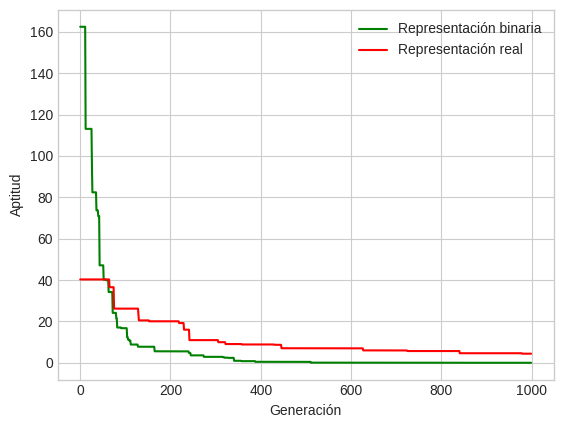

In [41]:
plt.plot(record_1B[indx_median_1B], label='Representación binaria', color='g')
plt.plot(record_1R[indx_median_1R], label='Representación real', color='r')

plt.xlabel("Generación")
plt.ylabel("Aptitud")
plt.legend() 
plt.show()

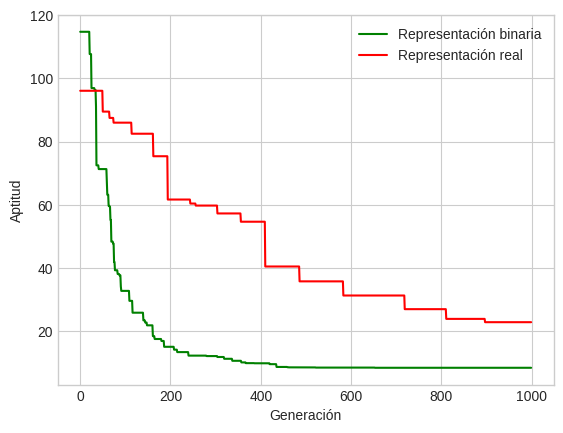

In [42]:
plt.plot(record_2B[indx_median_2B], label='Representación binaria', color='g')
plt.plot(record_2R[indx_median_2R], label='Representación real', color='r')

plt.xlabel("Generación")
plt.ylabel("Aptitud")
plt.legend() 
plt.show()

### Numerical_results

In [43]:
df_1B = pd.DataFrame(np.array(sons_1B))
print(df_1B)
print("Best result at row:", int(best_1B[0,0]))

        0      1      2      3      4      5      6      7      8      9
0  -0.008  0.000  0.002  0.003  0.006 -0.002  0.003 -0.004 -0.008 -0.009
1   0.008 -0.001 -0.005 -0.033  0.011  0.002 -0.018  0.016  0.005  0.010
2   0.003 -0.012  0.027  0.026 -0.024 -0.005  0.013 -0.000  0.003 -0.000
3  -0.008 -0.005  0.003 -0.016 -0.009  0.002  0.015  0.028 -0.002 -0.001
4  -0.008  0.005  0.013  0.003 -0.008 -0.007  0.008 -0.009  0.004 -0.001
5  -0.004  0.015  0.001 -0.020 -0.015 -0.003 -0.020 -0.078  0.000  0.001
6  -0.025  0.024  0.002 -0.011 -0.022 -0.003 -0.006  0.008  0.005 -0.011
7   0.002 -0.005  0.006  0.000 -0.005 -0.005  0.000 -0.013 -0.000 -0.006
8  -0.005  0.002 -0.025 -0.023 -0.002  0.001  0.006 -0.008  0.022  0.001
9   0.000  0.000  0.020  0.003 -0.011  0.018 -0.006 -0.005 -0.013 -0.020
10  0.000  0.016  0.005  0.030 -0.000  0.009  0.001 -0.003 -0.000 -0.009
11  0.000  0.005  0.014 -0.011 -0.011  0.000  0.009  0.003 -0.015  0.008
12  0.001 -0.009 -0.002 -0.157  0.010  0.017  0.001

In [48]:
print(df_1B.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format,))  

\begin{tabular}{rrrrrrrrrr}
\toprule
0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 \\
\midrule
-0.008 & 0.000 & 0.002 & 0.003 & 0.006 & -0.002 & 0.003 & -0.004 & -0.008 & -0.009 \\
0.008 & -0.001 & -0.005 & -0.033 & 0.011 & 0.002 & -0.018 & 0.016 & 0.005 & 0.010 \\
0.003 & -0.012 & 0.027 & 0.026 & -0.024 & -0.005 & 0.013 & -0.000 & 0.003 & -0.000 \\
-0.008 & -0.005 & 0.003 & -0.016 & -0.009 & 0.002 & 0.015 & 0.028 & -0.002 & -0.001 \\
-0.008 & 0.005 & 0.013 & 0.003 & -0.008 & -0.007 & 0.008 & -0.009 & 0.004 & -0.001 \\
-0.004 & 0.015 & 0.001 & -0.020 & -0.015 & -0.003 & -0.020 & -0.078 & 0.000 & 0.001 \\
-0.025 & 0.024 & 0.002 & -0.011 & -0.022 & -0.003 & -0.006 & 0.008 & 0.005 & -0.011 \\
0.002 & -0.005 & 0.006 & 0.000 & -0.005 & -0.005 & 0.000 & -0.013 & -0.000 & -0.006 \\
-0.005 & 0.002 & -0.025 & -0.023 & -0.002 & 0.001 & 0.006 & -0.008 & 0.022 & 0.001 \\
0.000 & 0.000 & 0.020 & 0.003 & -0.011 & 0.018 & -0.006 & -0.005 & -0.013 & -0.020 \\
0.000 & 0.016 & 0.005 & 0.030 & -0.000 & 0.009 & 0

In [44]:
df_1R = pd.DataFrame(np.array(sons_1R))
print(df_1R)
print("Best result at row:", int(best_1R[0,0]))

        0      1      2      3      4      5      6      7      8      9
0   0.003 -0.368 -0.090  0.304 -0.414 -0.302 -0.076  0.401  0.217 -0.107
1   0.184  0.168  0.258  0.044  0.399  0.054 -0.137  0.653 -0.092  0.317
2  -1.781  0.224 -0.423 -0.474  0.344 -0.240 -0.365  0.503 -0.410 -0.214
3  -0.448 -0.007  0.117  0.702  0.080 -0.453 -0.156  0.254  1.294  0.276
4   2.766 -0.164 -0.230 -0.015 -0.574 -0.482  0.632 -0.049 -0.027  0.643
5   0.908 -0.085 -0.281  0.192 -0.065  0.030 -0.217  0.183  0.014  1.819
6  -6.291 -0.055  0.001 -0.188  0.695  0.262  0.424  0.559 -0.189 -1.294
7  -0.273 -0.374 -0.125  0.292  0.477  0.214 -0.090  0.462  0.718 -0.071
8   0.041  0.144 -0.531  0.426  0.238 -0.599 -0.844  0.266 -0.692 -0.291
9   0.750 -0.338  0.032 -0.574  0.694  0.011 -0.312  0.079  0.173  0.045
10 -0.424  0.117  0.088 -0.009 -0.473 -0.220  0.179 -0.588  0.309  0.082
11 -1.966 -1.182  0.657  0.329  0.078 -0.686 -0.380  0.297  0.046  0.354
12 -2.358  0.073  0.179  0.300 -0.403 -0.011 -0.235

In [45]:
df_2B = pd.DataFrame(np.array(sons_2B))
print(df_2B)
print("Best result at row:", int(best_2B[0,0]))

        0      1      2      3      4      5      6      7      8      9
0  -0.960  0.000  0.960 -0.000  0.997 -0.000 -0.000 -0.000  1.920 -0.960
1  -0.000  0.000 -0.994 -1.000 -0.001  0.001  1.000 -1.000 -1.990  0.000
2   0.008  1.990  0.959 -0.002 -0.001 -0.005  0.960 -1.990 -1.990  0.960
3   0.995  2.000  0.000 -1.000  0.000  0.000  0.995  0.000 -0.001  1.000
4   0.003  0.959  0.003 -0.958  0.999 -0.995 -1.000 -0.960 -1.980 -0.001
5  -0.995  2.000 -2.005  0.992  1.007  0.903 -0.959  0.997  0.001  0.995
6  -0.000 -0.000 -1.990 -0.995 -0.001 -0.960  0.000  0.994 -0.960 -0.000
7   0.000 -0.000  1.000  2.000  0.995  0.995 -0.960  0.996 -0.000  0.001
8  -0.000 -0.995  0.995  1.994 -0.997  0.000  1.002 -0.000  0.000 -0.997
9  -0.000  0.001 -1.920  0.000  0.010 -0.000 -1.000 -0.000 -0.960 -0.995
10  1.000  0.994 -1.000 -0.002  0.995  1.000  0.996 -0.994 -0.000  1.000
11  0.000 -0.000 -0.995 -0.995 -0.000  2.002  0.001  0.960 -0.000 -0.995
12  0.000 -0.000  0.997  0.960 -0.000  1.989 -0.960

In [46]:
df_2R = pd.DataFrame(np.array(sons_2R))
print(df_2R)
print("Best result at row:", int(best_2R[0,0]))

        0      1      2      3      4      5      6      7      8      9
0   0.843  0.065  0.002  0.046 -0.998 -0.987  0.017  0.992 -1.024 -2.080
1   2.980  0.044  0.047 -1.001 -0.029  0.947 -0.953 -0.929 -0.936 -1.014
2   0.276 -1.962  1.911  2.036 -1.007  1.052 -0.918 -0.058 -1.053  1.043
3   1.206  1.002 -1.098 -0.823  0.054  0.037 -0.016 -0.022  1.064 -0.930
4  -0.354 -0.944  0.133 -1.010 -0.156 -1.042  0.060  0.100 -0.941 -1.007
5   1.422  1.027 -0.019  0.028  0.999  0.092  0.009 -0.864 -0.013  0.004
6   1.777  1.000 -1.930 -0.954 -0.969 -0.011  0.977  0.989  0.073  0.086
7  -0.961 -1.048  0.142  0.884 -0.023  0.953 -0.004  0.036  0.988 -0.990
8  -1.749 -0.955  0.961 -0.012  0.106  0.926 -0.921  1.061  0.046  1.032
9   0.888 -0.064  0.065  0.063  0.984 -0.033 -0.956 -0.993 -0.954 -0.058
10 -2.278 -0.053 -1.032 -0.022 -1.107 -1.002  0.122  0.980  1.078  1.070
11  0.016 -0.961 -0.036 -2.005  0.012 -0.937  0.027  0.980 -0.984  1.155
12  1.081 -1.104  1.085 -0.019  0.937  0.046 -1.151